# CMIP6 ECS Calculation from Pangeo Gallery

## Imports
We start **first** with some imports related to the cacheing functionality in [`xpersist`](https://github.com/NCAR/xpersist)

In [97]:
import os

os.environ["PREFECT__FLOWS__CHECKPOINTING"] = "True"

import tempfile
import time

import prefect
import xcollection as xc
from prefect import Flow, Parameter, task, unmapped
from xpersist import CacheStore, XpersistResult

prefect.context.to_dict()['config']['flows']['checkpointing']

True

Next, we install the rest of our libraries/packages

In [120]:
import warnings

import cartopy
import dask
import fsspec
import intake
import numpy as np
import pandas as pd
import xarray as xr
from distributed import Client
from matplotlib import pyplot as plt
from ncar_jobqueue import NCARCluster
from tqdm.autonotebook import tqdm

warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

## Spin up a Dask Cluster

In [3]:
cluster = NCARCluster()
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41865,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in our data using an `Intake-ESM` Catalog
We load in the "Pangeo CMIP6 Catalog"

In [5]:
data_catalog = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json",
)

### Query for a single "source_id"

In [6]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',
    source_id='ACCESS-CM2',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)
col_subset = data_catalog.search(**query)
col_subset.df.groupby("source_id")['member_id'].unique()
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
2,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
3,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
4,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
5,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
7,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112


### Load in the data using `.to_collection()`
We can now load in our subset of the original catalog, reading it in as an `xcollection`, which is a more sophisticated dictionary of datasets

In [121]:
collection = col_subset.to_collection(storage_options={'anon': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Define Operators
We are now ready to define some "operators" which are functions which operate on `xarray.Datasets`...

The key here is that they read in an `xarray.Dataset`, and return an `xarray.Dataset`

In [8]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)


def yearly_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out


def imbalance(ds):
    ds['imbalance'] = ds.rsdt - ds.rsut - ds.rlut
    ds['imbalance'].attrs['long_name'] = 'Global Mean Radiative Imbalance'
    ds['imbalance'].attrs['units'] = 'W m$^{-2}$'
    return ds

### Compute anomalies based on the "piControl" run

In [9]:
pi_control = collection['CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn']

In [10]:
anom_collection = collection
for key in anom_collection.keys():
    anom_collection[key] = anom_collection[key] - pi_control.mean(dim='time')

### Apply our operators to our `xcollections`
We can apply our operators using the `.map()` syntax

In [11]:
ecs_collection = collection.map(yearly_mean).map(global_mean).map(imbalance)
ecs_collection_anom = anom_collection.map(yearly_mean).map(global_mean).map(imbalance)

In [93]:
def find_picontrol(dsets, keys):
    collection = xc.Collection(dict(zip(keys, dsets)))
    for key in keys:
        if 'piControl' in key:
            pi_control_key = key

    return collection[pi_control_key]

In [95]:
find_picontrol(ecs_collection.values(), ecs_collection.keys())

<xarray.Dataset>
Dimensions:    (time: 500)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1449-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [12]:
print(ecs_collection)
print(ecs_collection_anom)

<Collection (2 keys)>
🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 150)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1099-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 500)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1449-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut    

## Plot the Fields

We start by subsetting for the first 150 years

In [20]:
first_150_years = slice(0, 149)

We setup another function to visualize our data

In [21]:
def plot_field(ds, field, time_subset=first_150_years, ax=None, title=None):
    ds.isel(time=time_subset)[field].plot(ax=ax)
    if title:
        plt.title(title)
    return ds

We can use `.map()` again in this case!

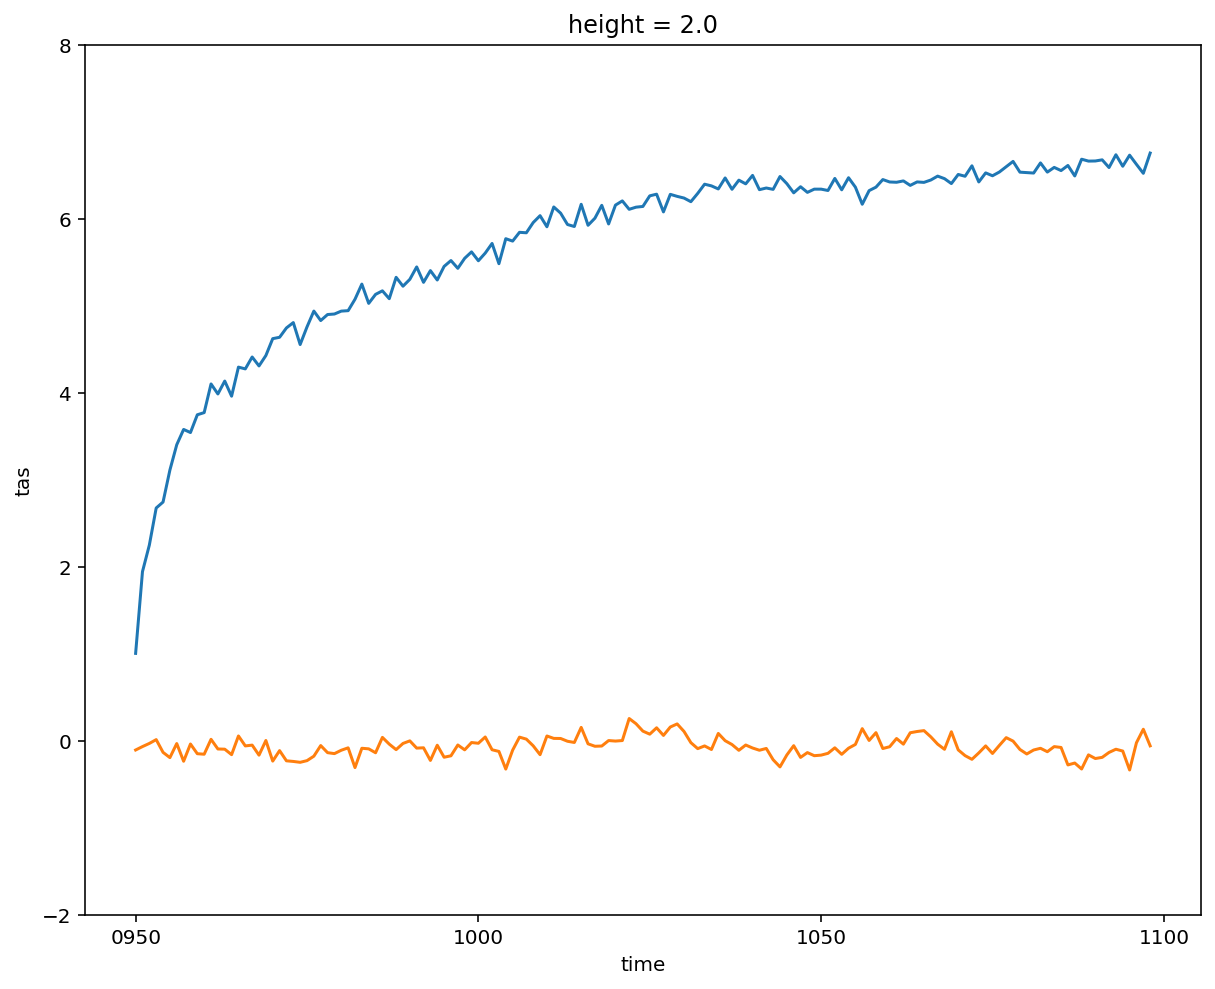

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plt.ylim(-2, 8)
plt.xlabel('Year')
ecs_collection.map(plot_field, field='tas', ax=ax)

plt.show()

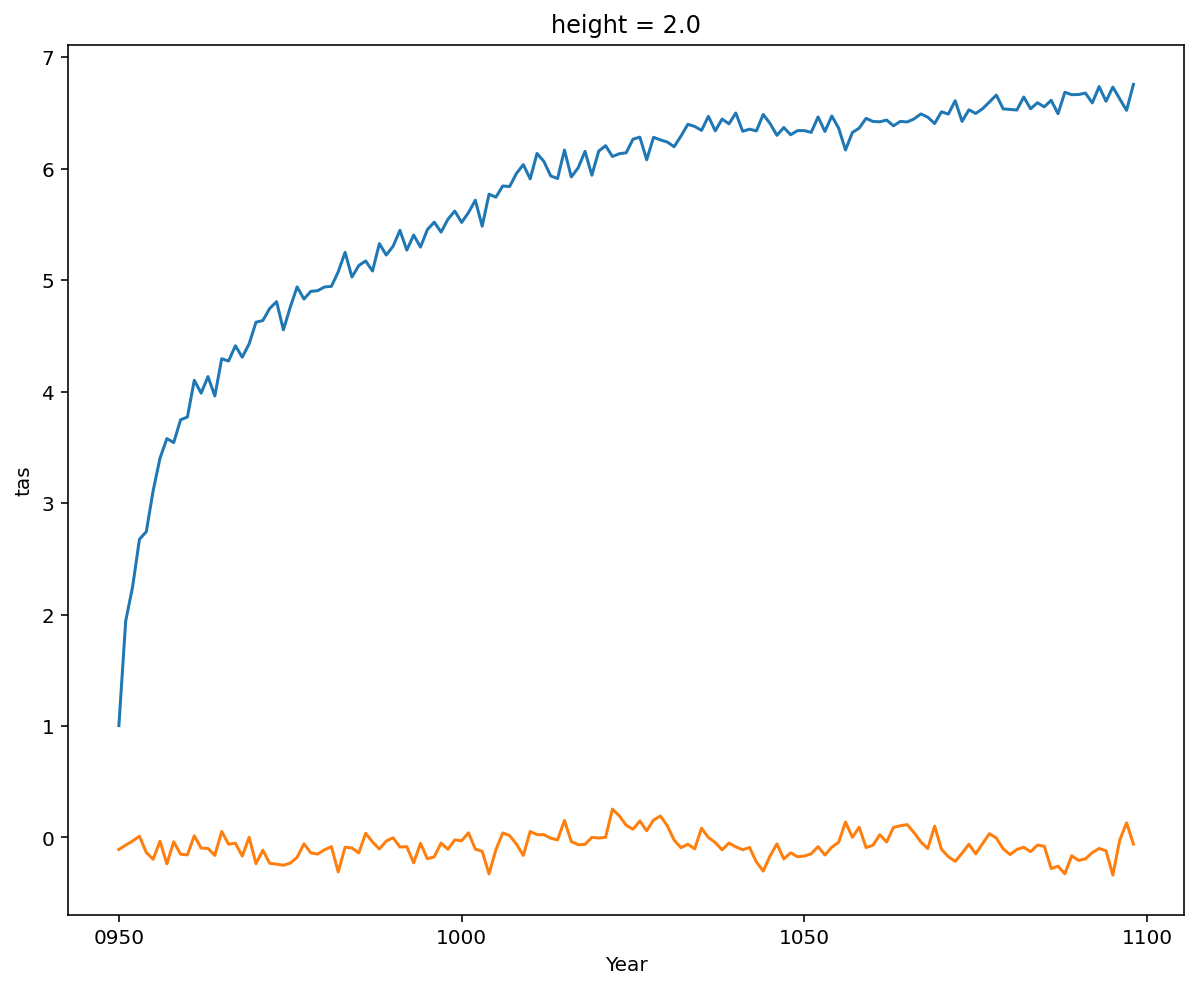

In [23]:
fig = plt.figure(figsize=(10, 8))
ecs_collection_anom.map(plot_field, field='tas')
plt.xlabel('Year')
plt.show()

### Calculate Equilibrium Climate Sensitivity (ECS)
Our last calculation is ECS, which can be computed using the anomaly collection

In [24]:
def calc_ecs(ds):
    ds = ds.isel(time=first_150_years)

    # Some sources don't have all 150 years, drop those missing values.
    a, b = np.polyfit(ds.tas.dropna("time"), ds.imbalance.dropna("time"), 1)
    ecs = -0.5 * (b / a)
    return xr.DataArray(ecs).to_dataset(name='ecs')

In [25]:
ecs = calc_ecs(ecs_collection_anom['CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn'])
ecs

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ecs      float64 4.683

## Writing this as a Prefect Workflow
We can now write this as a `Prefect` workflow!

### Setup your Cache Location

In [68]:
store = CacheStore(f'{tempfile.gettempdir()}/my-cache-2')
store

CacheStore(path='/glade/scratch/mgrover/my-cache-2', readonly=False, on_duplicate_key=<DuplicateKeyEnum.skip: 'skip'>, storage_options={})

### Setup your Tasks
Now that we have our `CacheStore` setup, we can put together some `tasks`

In [106]:
@task
def read_catalog(path, multivar_row=False):
    if multivar_row:
        read_csv_kwargs = {"converters": {"variables": ast.literal_eval}}
    else:
        read_csv_kwargs = None

    return intake.open_esm_datastore(path, read_csv_kwargs=read_csv_kwargs)


@task
def get_collection_values(collection):
    return list(collection.values())


@task
def get_collection_keys(collection):
    return list(collection.keys())


@task
def subset_catalog(intake_esm_catalog, search_dict):
    return intake_esm_catalog.search(**search_dict)


@task
def load_catalog(intake_esm_catalog, cdf_kwargs={}):
    return intake_esm_catalog.to_collection(cdf_kwargs=cdf_kwargs)


@task
def annual_average(ds, key):
    return yearly_mean(ds)


@task
def global_average(ds, key):
    return global_mean(ds)


@task
def find_picontrol(dsets, keys):
    collection = xc.Collection(dict(zip(keys, dsets)))
    for key in keys:
        if 'piControl' in key:
            pi_control_key = key

    return collection[pi_control_key]


@task(
    target="{flow_name}-{task_name}-{key}.zarr",
    result=XpersistResult(store, serializer="xarray.zarr", serializer_dump_kwargs={"mode": "w"}),
)
def calc_imbalance(ds, key):
    return imbalance(ds)


@task(
    target="{flow_name}-{task_name}-{key}.zarr",
    result=XpersistResult(store, serializer="xarray.zarr", serializer_dump_kwargs={"mode": "w"}),
)
def calc_anomaly(ds, key, pi_control_ds):
    return ds - pi_control_ds.mean(dim='time')


@task
def create_tseries_plot(values, keys, fig=None, ax=None, title=None, field='tas'):
    collection = xc.Collection(dict(zip(keys, values)))
    if not fig:
        fig = plt.figure()

    if not ax:
        ax = plt.subplot(111)

    collection.map(plot_field, field=field, ax=ax, title=title)

    return plt.show()

### Setup our Flow
There two primary sections to our flow:
* Parameters (ex. `path`), which are essentially inputs to our flow, with an option to set a default value
* Tasks (ex. `load_catalog`), which were defined in the cell above, which can take `Parameters` as input

In [112]:
from prefect import flatten

with Flow('ecs_flow') as ecs_flow:

    path = Parameter('path', default="https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    search_dict = Parameter("search_dict", default={})
    cdf_kwargs = Parameter("cdf_kwargs", default={})
    field_to_plot = Parameter("field_to_plot", default='imbalance')

    # Read the `intake-esm` catalog
    data_catalog = read_catalog(path)

    # Subset the catalog
    catalog_subsetted = subset_catalog(data_catalog, search_dict)

    # Load the catalog into the workflow
    collection_of_datasets = load_catalog(catalog_subsetted, cdf_kwargs=cdf_kwargs)

    # Calculate the annual average
    values = get_collection_values(collection_of_datasets)
    keys = get_collection_keys(collection_of_datasets)
    yearly_avg_dsets = annual_average.map(values, keys)

    # Calculate the global average
    global_annual_average = global_average.map(yearly_avg_dsets, keys)

    # Calculate the imbalance
    imbalance_dsets = calc_imbalance.map(global_annual_average, keys)

    # Calculate the imbalance anomaly
    pi_control_ds = find_picontrol(imbalance_dsets, keys)
    anomaly_dsets = calc_anomaly.map(imbalance_dsets, keys, unmapped(pi_control_ds))

    # Plot the resultant outputs
    plot = create_tseries_plot(
        imbalance_dsets, keys, field=field_to_plot, title=f'Global Annual Average'
    )
    plot2 = create_tseries_plot(
        anomaly_dsets, keys, field=field_to_plot, title=f'Global Annual Average Anomaly'
    )

Before we execute our plot, let's take a look at the visualization of what will happen with our data

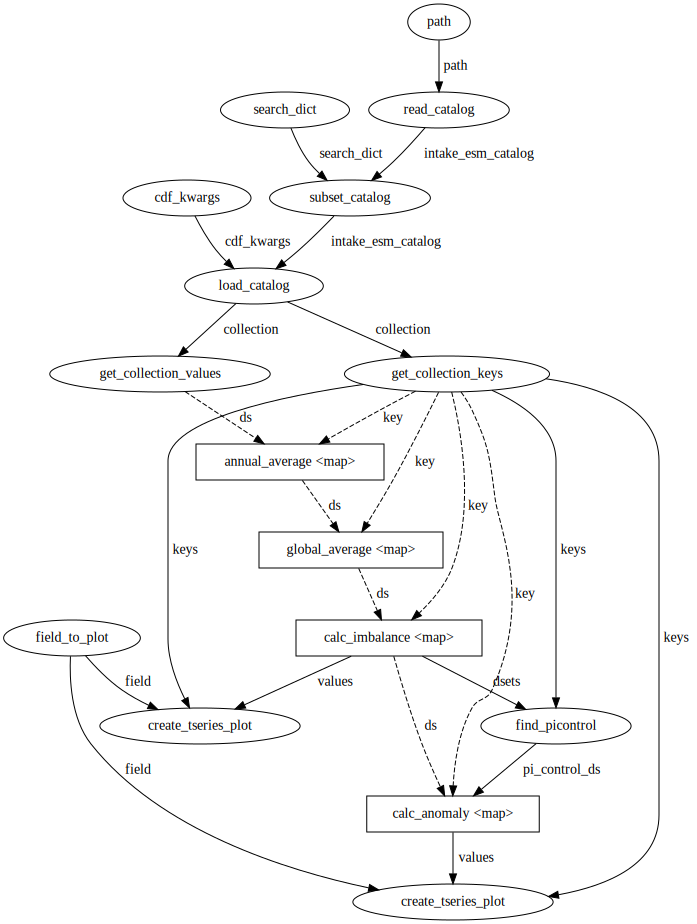

In [113]:
ecs_flow.visualize()

### Run our Prefect Flow
Now, we can run our flow!

We start with the same `query` we used before

[2021-12-22 09:54:55-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'ecs_flow'
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'search_dict': Starting task run...
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'search_dict': Finished task run for task with final state: 'Success'
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'cdf_kwargs': Starting task run...
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'cdf_kwargs': Finished task run for task with final state: 'Success'
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'field_to_plot': Starting task run...
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'field_to_plot': Finished task run for task with final state: 'Success'
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'path': Starting task run...
[2021-12-22 09:54:55-0700] INFO - prefect.TaskRunner | Task 'path': Finished task run for task with final state: 'Success'
[2021-12-22 09:54:5

[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'load_catalog': Finished task run for task with final state: 'Success'
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'get_collection_values': Starting task run...
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'get_collection_values': Finished task run for task with final state: 'Success'
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'get_collection_keys': Starting task run...
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'get_collection_keys': Finished task run for task with final state: 'Success'
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'annual_average': Starting task run...
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'annual_average': Finished task run for task with final state: 'Mapped'
[2021-12-22 09:55:02-0700] INFO - prefect.TaskRunner | Task 'annual_average[0]': Starting task run...
[2021-12-22 09:55:09-0700] INFO - prefect.TaskRu

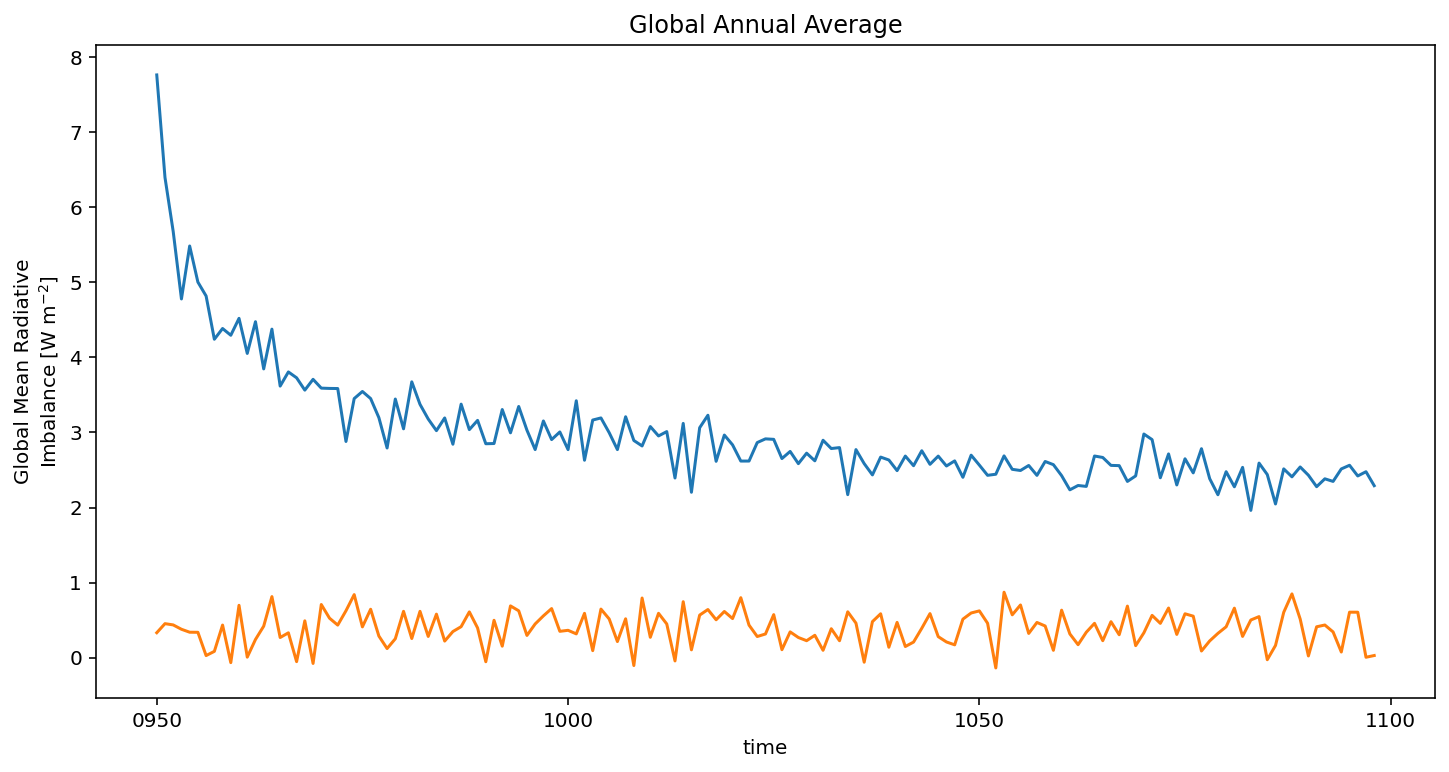

[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'create_tseries_plot': Finished task run for task with final state: 'Success'
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly': Starting task run...
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly': Finished task run for task with final state: 'Mapped'
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly[0]': Starting task run...
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly[0]': Finished task run for task with final state: 'Cached'
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly[1]': Starting task run...
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'calc_anomaly[1]': Finished task run for task with final state: 'Cached'
[2021-12-22 09:55:35-0700] INFO - prefect.TaskRunner | Task 'create_tseries_plot': Starting task run...


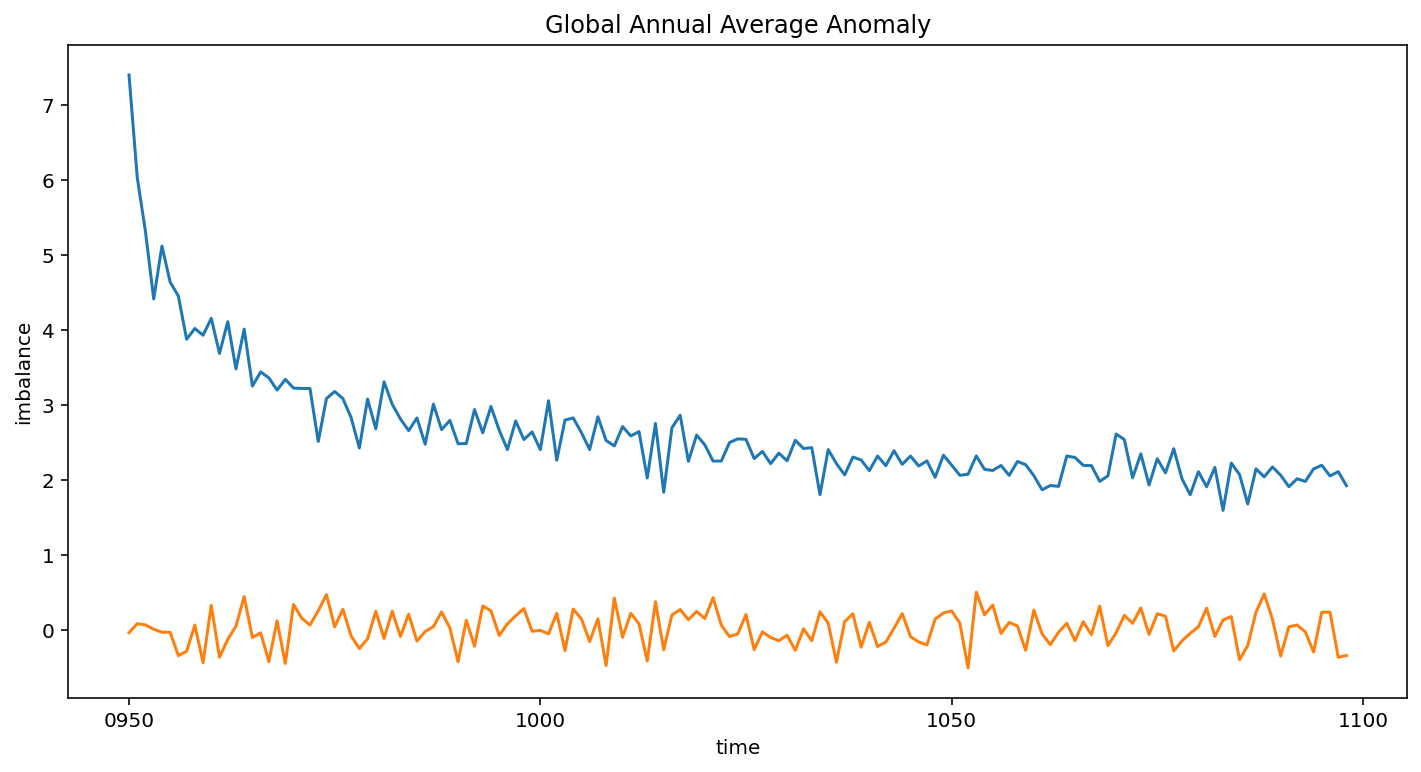

[2021-12-22 09:55:36-0700] INFO - prefect.TaskRunner | Task 'create_tseries_plot': Finished task run for task with final state: 'Success'
[2021-12-22 09:55:36-0700] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


<Success: "All reference tasks succeeded.">

In [122]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',
    source_id='ACCESS-CM2',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)
ecs_flow.run(search_dict=query)

### Investigating the Output
The result of our flow is the output shown above, as well as our `cache` (within the `store` variable), which we can investigate using `.keys()`

In [116]:
store.keys()

['ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr',
 'ecs_flow-calc_imbalance-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr',
 'ecs_flow-calc_imbalance-CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn.zarr',
 'ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn.zarr']

If we wanted to read in one of these datasets, we can use `.get()`

In [117]:
store.get('ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr')

<xarray.Dataset>
Dimensions:    (time: 150)
Coordinates:
    height     float64 ...
  * time       (time) object 0950-01-01 00:00:00 ... 1099-01-01 00:00:00
Data variables:
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>